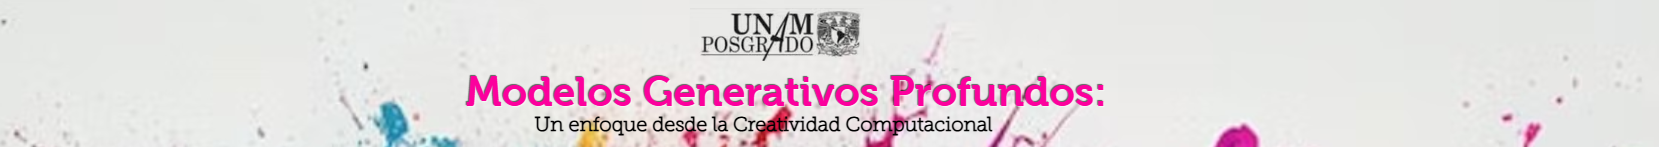

#Creación de un Autocodificador usando el dataset Fashion MNIST

En este cuaderno, recorreremos los pasos necesarios para entrenar tu propio autocodificador en el conjunto de datos Fashion MNIST.

Montamos el drive de Google (para salvar checkpoints).

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import layers, models, datasets, callbacks
import tensorflow.keras.backend as K

## 1. Descargar el datset

In [3]:
(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()

## 2. Preprocesamiento

In [4]:
def preprocesa(imgs):
    """
    Normaliza y cambia el tamaño de las imágenes
    """
    imgs = imgs.astype("float32") / 255.0
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=0.0) # Agrega un borde negro
    imgs = np.expand_dims(imgs, -1) # Agrega una dimensión al final para indicar que hay solo canal (escala de grises)
    return imgs


x_train = preprocesa(x_train)
x_test = preprocesa(x_test)

**Mostramos 10 imágenes aleatorias**

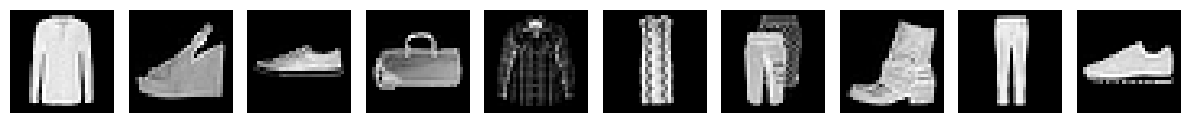

In [5]:
# Seleccionar 10 índices aleatorios
indices = np.random.choice(len(x_train), size=10, replace=False)

# Crear la figura
plt.figure(figsize=(12, 3))

for i, idx in enumerate(indices):
    img = x_train[idx]  # (alto, ancho, 1)

    plt.subplot(1, 10, i+1)
    plt.imshow(img.squeeze(), cmap="gray")  # .squeeze() quita la dimensión del canal
    plt.axis("off")

plt.tight_layout()
plt.show()

## 2. Construcción del autocodificador

In [6]:
IMAGE_SIZE = 32
CHANNELS = 1
EMBEDDING_DIM = 2


# Codificador
encoder_input = layers.Input(
    shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), name="encoder_input"
)
x = layers.Conv2D(32, (3, 3), strides=2, activation="relu", padding="same")(
    encoder_input
)
x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(128, (3, 3), strides=2, activation="relu", padding="same")(x)
shape_before_flattening = K.int_shape(x)[1:]  # El decodificador necesitará esta info

x = layers.Flatten()(x)
encoder_output = layers.Dense(EMBEDDING_DIM, name="encoder_output")(x)

encoder = models.Model(encoder_input, encoder_output)
encoder.summary()

2025-09-22 23:28:17.130277: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2025-09-22 23:28:17.130394: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2025-09-22 23:28:17.130421: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.66 GB
I0000 00:00:1758605297.130961  419843 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1758605297.131335  419843 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 16, 16, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_output (Dense)          │ (None, 2)              │         4,098 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 96,770 (378.01 KB)

 Trainable params: 96,770 (378.01 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Decodificador alternativo
decoder_input = layers.Input(shape=(EMBEDDING_DIM,), name="decoder_input_alt")

# Expansión del vector latente
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)

# Bloque 1
x = layers.UpSampling2D(size=(2, 2))(x)
x = layers.Conv2D(128, (3, 3), padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(alpha=0.2)(x)

# Bloque 2
x = layers.UpSampling2D(size=(2, 2))(x)
x = layers.Conv2D(64, (3, 3), padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(alpha=0.2)(x)

# Bloque 3
x = layers.UpSampling2D(size=(2, 2))(x)
x = layers.Conv2D(32, (3, 3), padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(alpha=0.2)(x)

# Capa de salida
decoder_output = layers.Conv2D(
    CHANNELS,
    (3, 3),
    activation="sigmoid",
    padding="same",
    name="decoder_output"
)(x)

decoder = models.Model(decoder_input, decoder_output)
decoder.summary()


/Users/roicort/GitHub/PCIC/GenAI/.venv/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input_alt (InputLayer)  │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │         6,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_output (Conv2D)         │ (None, 32, 32, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 247,169 (965.50 KB)

 Trainable params: 246,721 (963.75 KB)

 Non-trainable params: 448 (1.75 KB)

In [8]:
# Autocodificador
autoencoder = models.Model(
    encoder_input, decoder(encoder_output)
)

autoencoder.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 16, 16, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_output (Dense)          │ (None, 2)              │         4,098 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_1 (Functional)       │ (None, 32, 32, 1)      │       247,169 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 343,939 (1.31 MB)

 Trainable params: 343,491 (1.31 MB)

 Non-trainable params: 448 (1.75 KB)

## 3. Entrenamiento de autocodificador

In [9]:
# Compilación del autocodificador
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")

In [15]:
checkpoint_path = "./checkpoints/model.keras"
log_dir = "./logs"

# Crea un checkpint para salvar el modelo
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=False,
    save_freq="epoch",
    monitor="loss",
    mode="min",
    save_best_only=True,
    verbose=0,
)

tensorboard_callback = callbacks.TensorBoard(log_dir=log_dir)

In [16]:
BATCH_SIZE = 100
EPOCHS = 3


autoencoder.fit(
    x_train,
    x_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_data=(x_test, x_test),
    callbacks=[model_checkpoint_callback, tensorboard_callback],
)

Epoch 1/3


2025-09-22 23:28:49.287356: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


600/600 ━━━━━━━━━━━━━━━━━━━━ 200s 326ms/step - loss: 0.2731 - val_loss: 0.2669
Epoch 2/3
600/600 ━━━━━━━━━━━━━━━━━━━━ 180s 301ms/step - loss: 0.2556 - val_loss: 0.2598
Epoch 3/3
600/600 ━━━━━━━━━━━━━━━━━━━━ 176s 293ms/step - loss: 0.2528 - val_loss: 0.2535


In [17]:
# Salva los modelos finales
import os

# Crear la carpeta si no existe
os.makedirs("./models", exist_ok=True)

autoencoder.save("./models/autoencoder.keras")
encoder.save("./models/encoder.keras")
decoder.save("./models/decoder.keras")

## 4. Reconstrucción usando el autoencoder

In [18]:
n_to_predict = 5000
example_images = x_test[:n_to_predict]
example_labels = y_test[:n_to_predict]

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


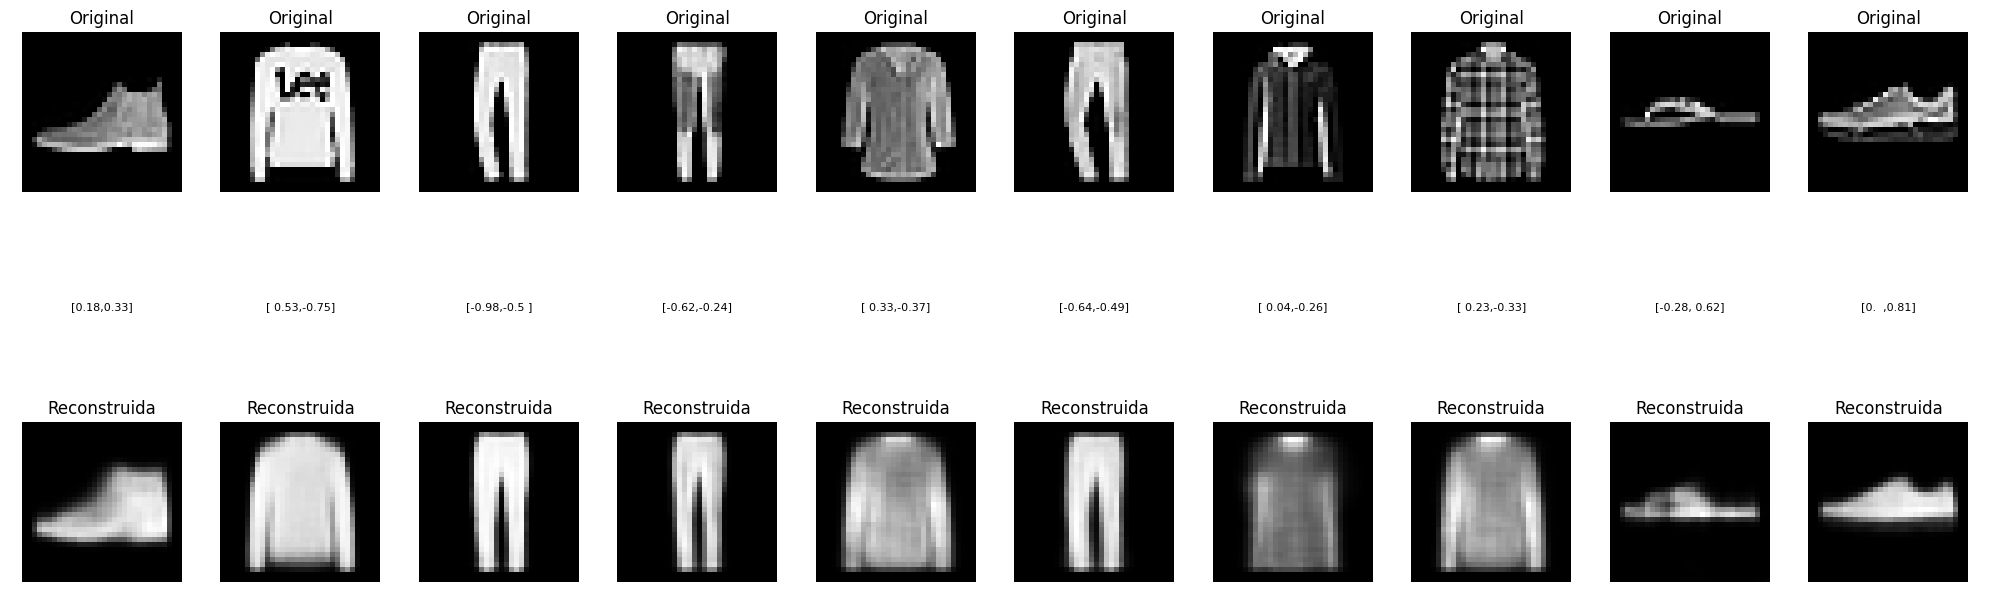

In [19]:
import matplotlib.pyplot as plt

predictions = autoencoder.predict(example_images)

# Obtener la representación latente z
z_vectors = encoder.predict(example_images)

# Número de ejemplos a visualizar
n = 10

plt.figure(figsize=(20, 6))

for i in range(n):
    # Imagen original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(example_images[i].squeeze(), cmap="gray")
    plt.title("Original")
    plt.axis("off")

    # Vector latente z (como texto en una celda)
    ax = plt.subplot(3, n, i + 1 + n)
    ax.axis("off")
    z_text = np.array2string(z_vectors[i], precision=2, separator=",")
    ax.text(0.5, 0.5, z_text, ha="center", va="center", fontsize=8)

    # Reconstrucción
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(predictions[i].squeeze(), cmap="gray")
    plt.title("Reconstruida")
    plt.axis("off")

plt.tight_layout()
plt.show()


## 5. Codificando usando el codificador

In [20]:
# Codifica las imágenes de ejemplo
embeddings = encoder.predict(example_images)

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [21]:
# Algunos ejemplos codificados
print(embeddings[:10])

[[ 0.18165557  0.32857126]
 [ 0.5322899  -0.7463738 ]
 [-0.97730386 -0.50461686]
 [-0.61899066 -0.23980696]
 [ 0.32840955 -0.3736686 ]
 [-0.64075863 -0.4899789 ]
 [ 0.04211183 -0.26472837]
 [ 0.22517127 -0.33177352]
 [-0.2798549   0.61898726]
 [ 0.00322945  0.8092358 ]]


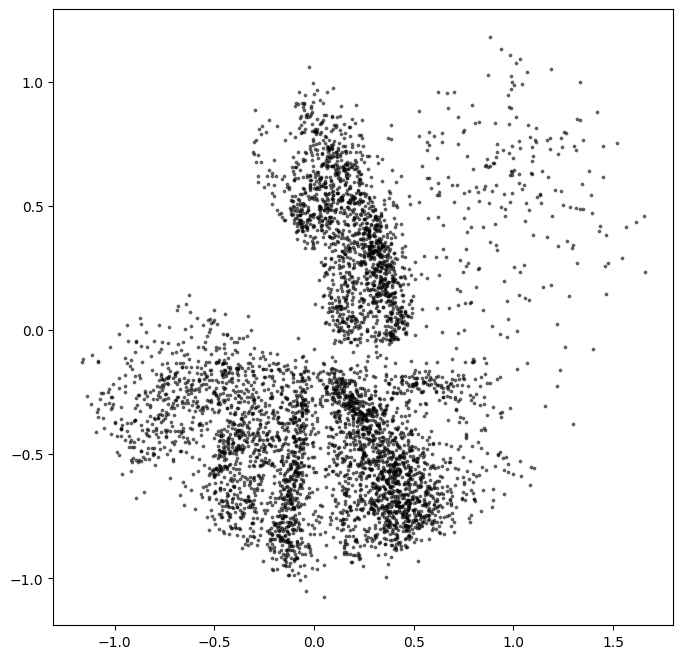

In [22]:
# Muestra los puntos codificados en el espacio 2D
figsize = 8

plt.figure(figsize=(figsize, figsize))
plt.scatter(embeddings[:, 0], embeddings[:, 1], c="black", alpha=0.5, s=3)
plt.show()

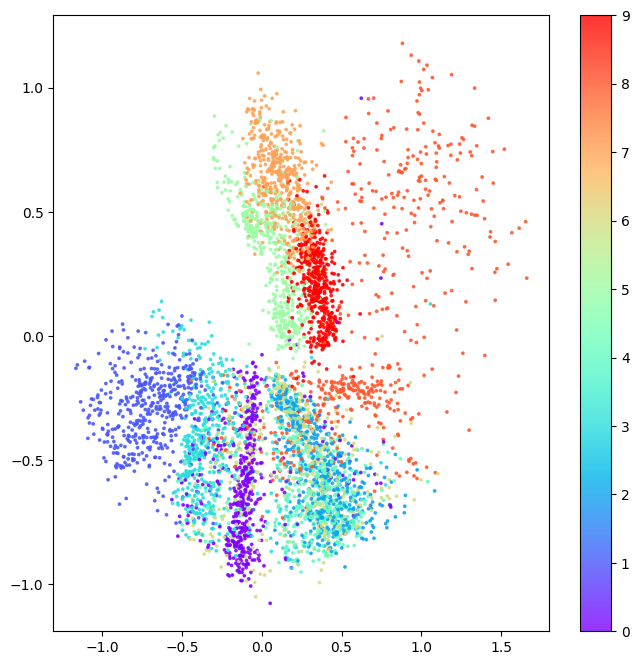

In [23]:
# Colores las codificaciones por su etiqueta
example_labels = y_test[:n_to_predict]

figsize = 8
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    embeddings[:, 0],
    embeddings[:, 1],
    cmap="rainbow",
    c=example_labels,
    alpha=0.8,
    s=3,
)
plt.colorbar()
plt.show()

## 6. Generación  usando el decodificador

In [24]:
# Se obtiene el rango de las codificaciones (embeddings) existentes
mins, maxs = np.min(embeddings, axis=0), np.max(embeddings, axis=0)

# Muestrea algunos puntos en el espacio latente
grid_width, grid_height = (6, 3)
sample = np.random.uniform(
    mins, maxs, size=(grid_width * grid_height, EMBEDDING_DIM)
)

In [25]:
# Decodifica los puntos muestreados
reconstructions = decoder.predict(sample)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


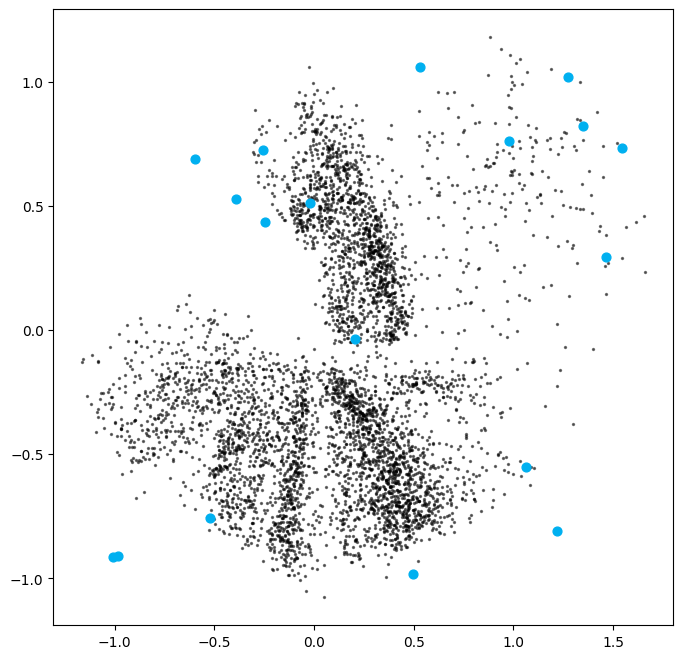

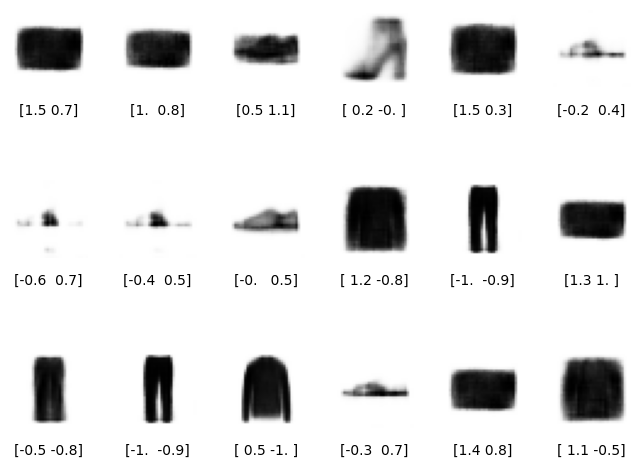

In [26]:
# Dibuja un plot
figsize = 8
plt.figure(figsize=(figsize, figsize))

# ... Las codificaciones originales  ...
plt.scatter(embeddings[:, 0], embeddings[:, 1], c="black", alpha=0.5, s=2)

# ... y los puntos nuevos generados en el espacio latente
plt.scatter(sample[:, 0], sample[:, 1], c="#00B0F0", alpha=1, s=40)
plt.show()

# Agrega debajo una cuadrícula de las imágenes decodificadas.
fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        str(np.round(sample[i, :], 1)),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


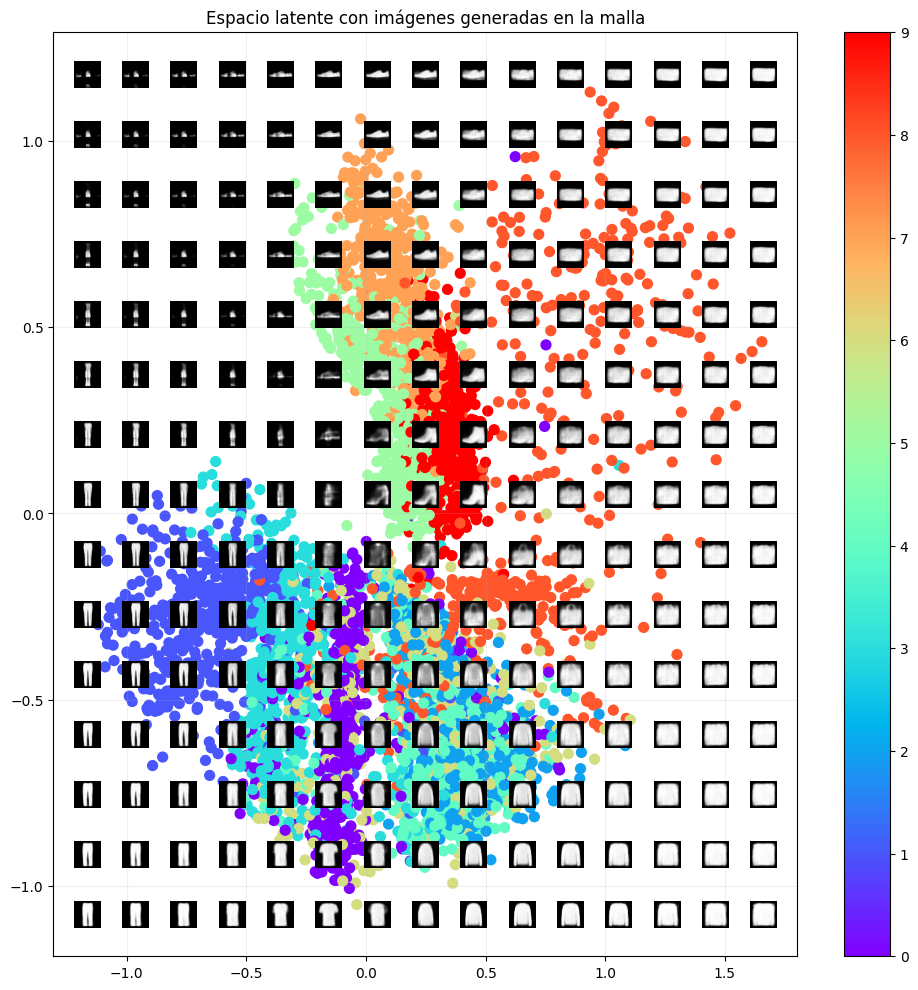

In [27]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

figsize = 12
grid_size = 15
plt.figure(figsize=(figsize, figsize))
ax = plt.gca()

# Dibujar embeddings de datos reales (opcional)
scatter = ax.scatter(
    embeddings[:, 0],
    embeddings[:, 1],
    cmap="rainbow",
    c=example_labels,
    s=50,
)
plt.colorbar(scatter, ax=ax)

# Crear la malla en el espacio latente
x = np.linspace(min(embeddings[:, 0]), max(embeddings[:, 0]), grid_size)
y = np.linspace(max(embeddings[:, 1]), min(embeddings[:, 1]), grid_size)
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
grid = np.array(list(zip(xv, yv)))

# Reconstrucciones del decodificador en esos puntos latentes
reconstructions = decoder.predict(grid)

# Pegar cada imagen reconstruida sobre el scatter en su coordenada (x,y)
for i in range(len(grid)):
    img = reconstructions[i].squeeze()
    imagebox = OffsetImage(img, zoom=0.6, cmap="gray")
    ab = AnnotationBbox(imagebox, (grid[i, 0], grid[i, 1]), frameon=False)
    ax.add_artist(ab)

plt.title("Espacio latente con imágenes generadas en la malla")
plt.grid(alpha=0.2)
plt.show()